# Análise exploratória de preços do Etherium (ETH/USDT)

Descrição resumida
- Script em Python para baixar OHLCV do par ETHUSDT da API da Binance, limpar e preparar os dados, calcular métricas/indicadores simples e gerar visualizações exploratórias.
- Etapas implementadas: coleta, limpeza, estatísticas descritivas, visualizações, correlação e feature engineering (médias móveis e volatilidade).

Dependências
- requests
- pandas
- numpy
- matplotlib
- seaborn

Instalação (exemplo)
```bash
pip install requests pandas numpy matplotlib seaborn
```

Principais funções/variáveis
- get_binance_ohlc(symbol="ETHUSDT", interval="1d", start=1493596800000, end=None)
    - Baixa candles (klines) da Binance e retorna DataFrame com colunas convertidas (datas e numéricos).
    - Parâmetro start em milissegundos (default começa em 2017).
- ETH_df
    - DataFrame final filtrado para ["open_time", "open", "high", "low", "close", "volume"] e ordenado por data.
    - Colunas adicionadas: `return` (pct_change), `SMA_7`, `SMA_30`, `volatilidade_7d`.

Outputs / Visualizações geradas
- Série temporal do preço de fechamento.
- Gráfico de volume diário.
- Histograma + KDE da distribuição dos retornos diários.
- Heatmap da matriz de correlação entre variáveis.
- Gráfico do preço com médias móveis (7d e 30d).
- Estatísticas descritivas impressas e contagem de linhas analisadas.

Observações importantes
- Requer conexão com a internet e acesso à API pública da Binance.
- Atenção a limites de taxa da API; para séries longas pagine chamadas ou implemente cache.
- O start padrão (1493596800000) é em ms; ajuste para período desejado.
- Valores NaN aparecem nas primeiras linhas ao calcular médias móveis e retornos (comportamento esperado).

Melhorias sugeridas
- Salvar o DataFrame em CSV/Parquet para análises futuras e evitar múltiplas chamadas.
- Implementar tratamento de exceções mais robusto e retry/backoff para requisições.
- Adicionar normalização, features adicionais (RSI, MACD) e pipeline para modelagem/forecast.
- Incluir argumentos CLI ou widgets para escolher período, símbolo e intervalo.

Licença
- Livre para uso/ajuste (adapte conforme necessidade do projeto).

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# COLETA DE DADOS
# ==============================
def get_binance_ohlc(symbol="ETHUSDT", interval="1d",
                      start=1493596800000, end=None):
    url = "https://api.binance.com/api/v3/klines"
    params = {"symbol": symbol, "interval": interval, "startTime": start, "endTime": end}
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()

    cols = ["open_time", "open", "high", "low", "close", "volume",
            "close_time", "quote_volume", "num_trades",
            "taker_base_vol", "taker_quote_vol", "ignore"]

    df = pd.DataFrame(data, columns=cols)
    df["open_time"] = pd.to_datetime(df["open_time"], unit='ms')
    df["close_time"] = pd.to_datetime(df["close_time"], unit='ms')
    df[["open", "high", "low", "close", "volume"]] = \
        df[["open", "high", "low", "close", "volume"]].astype(float)

    return df

# Baixar histórico do ETH para 2024
ETH_df = get_binance_ohlc("ETHUSDT")

In [3]:
# ==============================
# LIMPEZA E PREPARAÇÃO
# ==============================
# Remover colunas desnecessárias
ETH_df = ETH_df[["open_time", "open", "high", "low", "close", "volume"]]

# Verificar valores nulos
print("Valores nulos:\n", ETH_df.isna().sum())

# Garantir que está ordenado por data
ETH_df = ETH_df.sort_values("open_time").reset_index(drop=True)

# Adicionar uma coluna de 'retorno diário'
ETH_df["return"] = ETH_df["close"].pct_change()


Valores nulos:
 open_time    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64


In [4]:
# ==============================
# ESTATÍSTICAS DESCRITIVAS
# ==============================
print("\nResumo estatístico dos preços:")
print(ETH_df[["open", "high", "low", "close", "volume", "return"]].describe())



Resumo estatístico dos preços:
              open         high          low        close        volume  \
count   500.000000   500.000000   500.000000   500.000000  5.000000e+02   
mean    457.080720   477.235560   431.693140   456.727240  1.770015e+05   
std     266.917737   283.018088   246.493013   267.247387  2.034363e+05   
min      83.750000    85.000000    81.790000    83.760000  1.060567e+03   
25%     275.985000   285.377500   254.585000   275.565000  4.424238e+04   
50%     390.490000   413.000000   376.395000   390.445000  1.160428e+05   
75%     611.775000   631.425000   581.150000   611.847500  2.114070e+05   
max    1388.100000  1440.000000  1258.120000  1388.020000  1.319610e+06   

           return  
count  499.000000  
mean     0.000104  
std      0.058923  
min     -0.222816  
25%     -0.027470  
50%     -0.001522  
75%      0.029342  
max      0.218793  


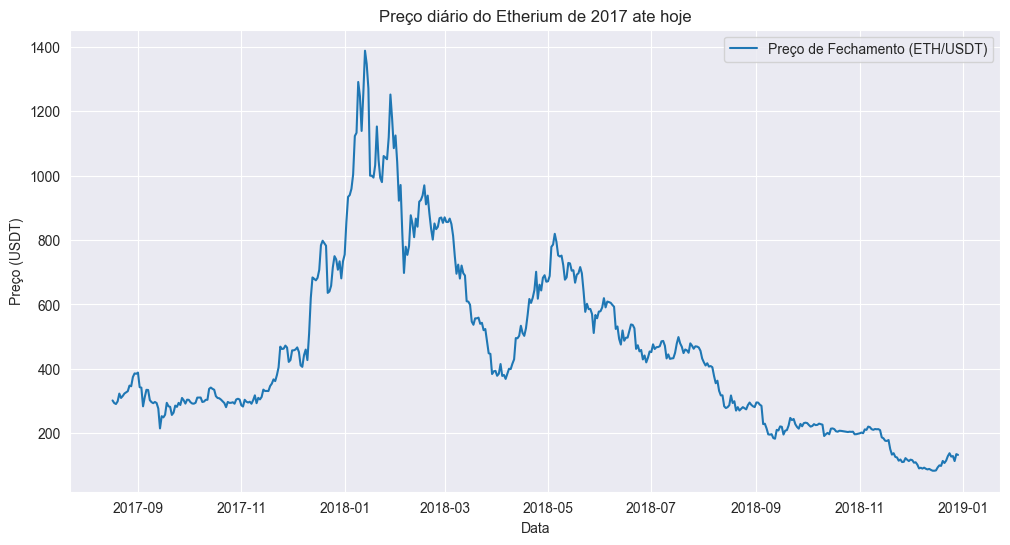

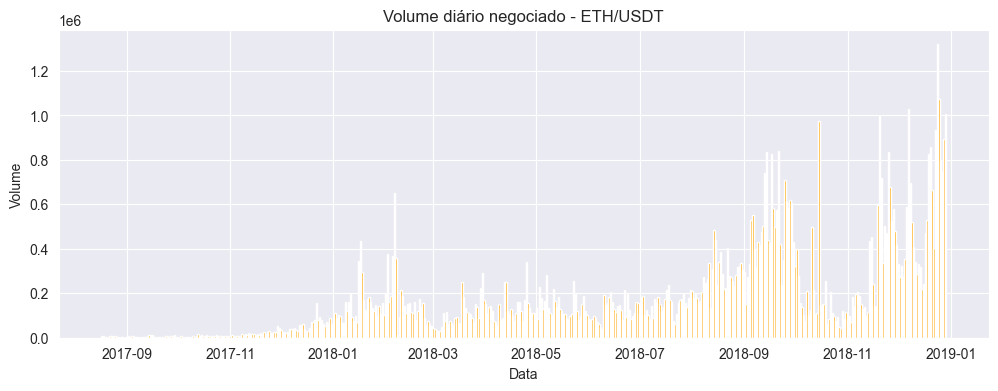

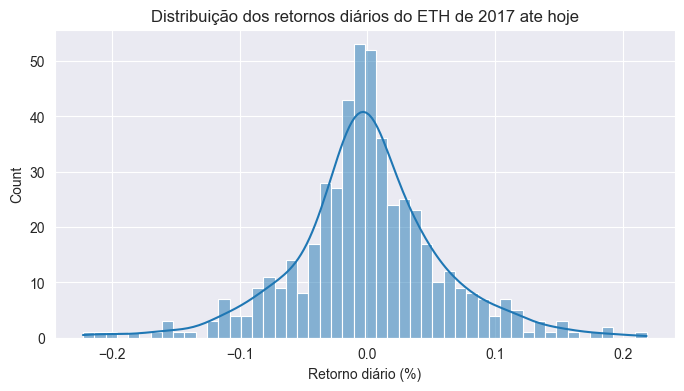

In [5]:
# ==============================
# VISUALIZAÇÕES EXPLORATÓRIAS
# ==============================
plt.figure(figsize=(12,6))
plt.plot(ETH_df["open_time"], ETH_df["close"], label="Preço de Fechamento (ETH/USDT)")
plt.title("Preço diário do Etherium de 2017 ate hoje")
plt.xlabel("Data")
plt.ylabel("Preço (USDT)")
plt.legend()
plt.grid(True)
plt.show()

# Volume negociado
plt.figure(figsize=(12,4))
plt.bar(ETH_df["open_time"], ETH_df["volume"], color="orange")
plt.title("Volume diário negociado - ETH/USDT")
plt.xlabel("Data")
plt.ylabel("Volume")
plt.show()

# Distribuição dos retornos
plt.figure(figsize=(8,4))
sns.histplot(ETH_df["return"].dropna(), bins=50, kde=True)
plt.title("Distribuição dos retornos diários do ETH de 2017 ate hoje")
plt.xlabel("Retorno diário (%)")
plt.show()


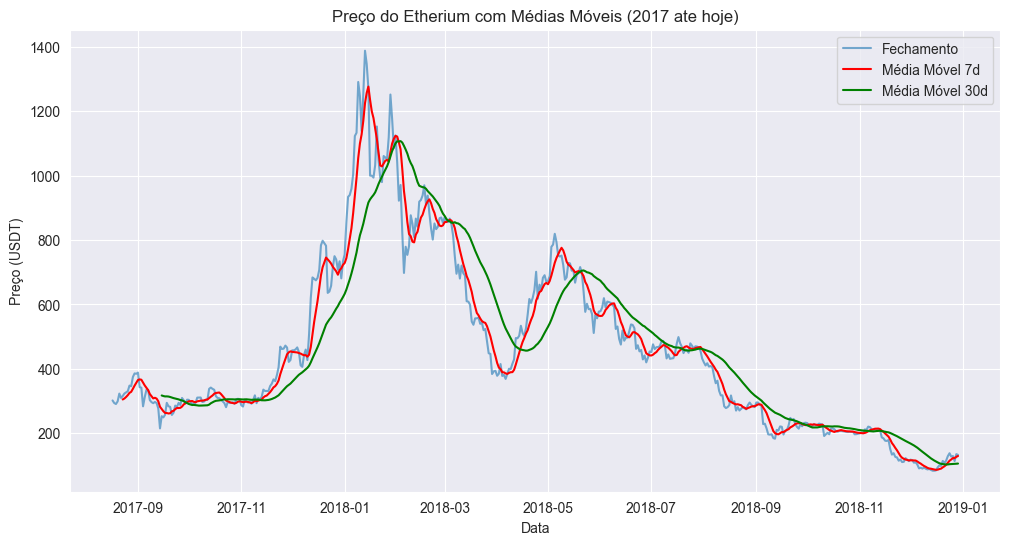

In [6]:
# ==============================
# FEATURE ENGINEERING (para predição futura)
# ==============================
# Médias móveis (tendência)
ETH_df["SMA_7"] = ETH_df["close"].rolling(window=7).mean()   # 1 semana
ETH_df["SMA_30"] = ETH_df["close"].rolling(window=30).mean() # 1 mês

# Volatilidade (desvio padrão dos retornos)
ETH_df["volatilidade_7d"] = ETH_df["return"].rolling(window=7).std()

# Gráfico com médias móveis
plt.figure(figsize=(12,6))
plt.plot(ETH_df["open_time"], ETH_df["close"], label="Fechamento", alpha=0.6)
plt.plot(ETH_df["open_time"], ETH_df["SMA_7"], label="Média Móvel 7d", color="red")
plt.plot(ETH_df["open_time"], ETH_df["SMA_30"], label="Média Móvel 30d", color="green")
plt.title("Preço do Etherium com Médias Móveis (2017 ate hoje)")
plt.xlabel("Data")
plt.ylabel("Preço (USDT)")
plt.legend()
plt.grid(True)
plt.show()


In [7]:

# ==============================
# Resultado final
# ==============================
print("\nAnálise exploratória concluída com sucesso!")
print("Linhas analisadas:", len(ETH_df))
ETH_df.tail()



Análise exploratória concluída com sucesso!
Linhas analisadas: 500


,open_time,open,high,low,close,volume,return,SMA_7,SMA_30,volatilidade_7d
495,2018-12-25,138.01,139.26,119.68,127.60,1.076164e+06,-0.075563,118.620000,104.363667,0.088601
496,2018-12-26,127.61,135.32,122.51,129.35,7.948341e+05,0.013715,122.992857,104.986000,0.086208
497,2018-12-27,129.35,131.09,111.22,113.80,7.521779e+05,-0.120216,122.957143,105.065000,0.089007
498,2018-12-28,113.75,136.66,111.87,135.30,8.944542e+05,0.188928,126.901429,105.478333,0.108048
499,2018-12-29,135.30,145.42,128.50,132.89,1.006654e+06,-0.017812,129.428571,105.975333,0.108834
